

# VARIATIONS TEMPORELLES DU BRUIT EN ANTARCTIQUE

---

**Description du Notebook :**
> Dans ce notebook est étudié comment le bruit sismique à évolué avec les différentes mesures sanitaires mises en place par le gouvernement.


---
# Importation des modules

In [1]:
%matplotlib inline

import datetime
import os
from glob import glob

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patheffects as pe
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import pandas as pd
import tqdm.notebook as tqdm
import warnings

from obspy import UTCDateTime, read
from obspy.clients.fdsn import Client
from obspy.clients.fdsn.client import FDSNNoDataException
from obspy.signal import PPSD

%load_ext autoreload
%autoreload 2
from seismic_noise import *
import seismosocialdistancing

---
# 1. Récupération des données

### Paramètres initiaux

In [30]:
### Paramètres généraux
load_data = False              # Recalculer les PPSDs et le déplacement RMS
freqs = [(2.0,8.0)]          # Bandes de fréquences à étudier 
st_file = "DATA/st_metadata/stations_antarctic.txt"  # Fichier de stations
noise_input_data = "B:/SeismicNoiseData/"
timeseries_data = "Files/noise_timeseries/"
PPSD_FOLDER  = "C:/Users/minid/Documents/Travail/PPSD"
DRMS_FOLDER  = "C:/Users/minid/Documents/Travail/DRMS"
MSEED_FOLDER = "C:/Users/minid/Documents/Travail/MSEED"
FIG_FOLDER = "RESULTS"
tStart = "2019-12-01"
tEnd = "2019-12-02"

### Conversion des périodes en UTCDateTime
periods = [[UTCDateTime(tStart), UTCDateTime(tEnd)]]

### Récupération des PPSDs et du déplacement RMS

In [31]:
st_name = np.loadtxt(st_file, dtype=str)
st_name = ["G.CCD.00.BHZ"]   # Station à étudier
dRMS = {}
for st_str in st_name:
    try:
        dataframe = pd.read_csv("{}/{}.csv".format(DRMS_FOLDER, st_str), index_col=0)
        dRMS[st_str] = dataframe
    except:
        pass
st_name = list(dRMS.keys())

In [32]:
dRMS.keys()

dict_keys(['G.CCD.00.BHZ'])

In [33]:
freq="2.0-8.0"
noise = dRMS[st_str][freq]
t, h, noise_matrix = hourly_var(noise, periods)



In [36]:
print(len(noise_matrix))

48


[1.24116951326e-09, 1.61538046448e-09, 9.80627665553e-10, 9.4634180894e-10, 1.02867488183e-09, 8.21978620253e-10, 1.73123727555e-09, 1.335889658e-10, 1.18791356238e-10, 1.28911462405e-10, 1.59179298559e-10, 2.74582571079e-10, 1.02143596342e-10, 8.79465261491e-11, 1.02385331807e-10, 9.10452596797e-11, 6.34130928023e-11, 7.57521548839e-11, 6.39894009556e-11, 6.67250719295e-11, 6.49433351222e-11, 6.94767539304e-11, 7.45014562354e-11, 6.19998212224e-11, 5.26311505569e-11, 6.51227067819e-11, 5.70093784422e-11, 6.85585953878e-11, 7.21805869772e-11, 1.81433454269e-10, 2.05094902913e-09, 2.02370032894e-09, 9.4057480343e-10, 5.97622383796e-10, 4.1600659412e-10, 1.26040762645e-09, 1.61514190851e-09, 7.07220085781e-10, 7.219096216e-10, 9.97300311892e-10, 1.10455048353e-09, 1.3957216072e-10, 1.6893874847e-10, 1.68488647679e-10, 7.55172194107e-10, 6.88017740879e-10, 1.31803769489e-09, 7.59773595785e-10, 1.64802533204e-09, 8.55651151925e-10, 2.43310048892e-09, 1.74879766637e-09, 1.72723212749e-09, 4

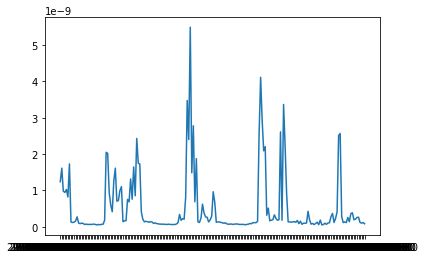

In [6]:
noise2 = noise.tolist()
print(noise2[:200])
print(h)
print(noise)
plt.plot(noise.index[:200],noise2[:200])


---
# 2. Variations horaires du bruit

## 2.1 Calcul de variations sur toute la période donnée

#### Tags à afficher sur le graphique

In [7]:
# à changer selon ce que l'on veut

tags = [
    ("2019-03-01", 6, "hiver"),
    ("2019-10-01", 6, "été"),
]

In [13]:
#décalage horaire été CCD
deca_hor=7

#décalage horaire été DRV
#deca_hor=10

#indice pour concatener la matrice pour prendre en compte le décalage horaire
indice=48-deca_hor*2


In [9]:
### Calcul de la variation du bruit

k = 1
for st_str in st_name:
    print("{}/{}    {}".format(k, len(st_name), st_str))
    for freq in dRMS[st_str].columns:

        try:
            noise = dRMS[st_str][freq]  # Série temporelle du bruit
        except:
            continue
        t, h, noise_matrix = hourly_var(noise, periods)
        grid = noise_matrix * 1e9  # Données en [nm]
        b=grid[indice:]
        a=grid[:indice]
        new_grid=np.concatenate((b,a))


        ### Mise en graphique de la variation du bruit
        plt.figure(figsize=(16, 8))
        plt.pcolormesh(t, h+0.25, new_grid)
        plt.clim(np.nanquantile(new_grid, 0.05), np.nanquantile(new_grid, 0.95))
        plt.colorbar(label="Déplacement [nm]")

        '''        ### Affichage des tags
        for (date, hour, text) in tags:
            # plt.scatter(np.datetime64(date), hour, zorder=50, s=40, color="red", edgecolors="white")
            plt.axvline(np.datetime64(date), zorder=50, color="white", ls="-")
            plt.text(np.datetime64(date)-8, 0.75, text, color="white", fontsize="medium", rotation=90)   # Confinement 1
        '''
        ### Configuration de l'axe vertical
        plt.ylabel("Heure locale")
        y_ticks = ["%ih" % j for j in range(1, 24)]
        y_loc = [j for j in range(1, 24)]
        plt.yticks(y_loc, y_ticks)
        plt.title("{} - [{}] Hz".format(st_str, freq))
        folder_path = FIG_FOLDER + "/ant_hourly_variations/" + st_str

        if not os.path.exists(folder_path): os.makedirs(folder_path)
        #plt.savefig("{}/hourly_temporal_2010-2020-{}.png".format(folder_path, freq), dpi=150)
        plt.close()
        plt.clf()
        
    k += 1
    
plt.show()

1/1    G.CCD.00.BHZ


<Figure size 432x288 with 0 Axes>

## 2.2 Calcul de variations horaires sur plusieurs sous-périodes

In [10]:
print(dRMS)

{'G.CCD.00.BHZ':                           2.0-8.0
2010-02-01 07:00:01  1.241170e-09
2010-02-01 07:30:01  1.615380e-09
2010-02-01 08:00:01  9.806277e-10
2010-02-01 08:30:01  9.463418e-10
2010-02-01 09:00:01  1.028675e-09
...                           ...
2020-12-31 21:30:00  8.086703e-11
2020-12-31 22:00:00  5.752790e-11
2020-12-31 22:30:00  4.803620e-11
2020-12-31 23:00:00  6.356195e-11
2020-12-31 23:30:00  5.473277e-11

[190360 rows x 1 columns]}


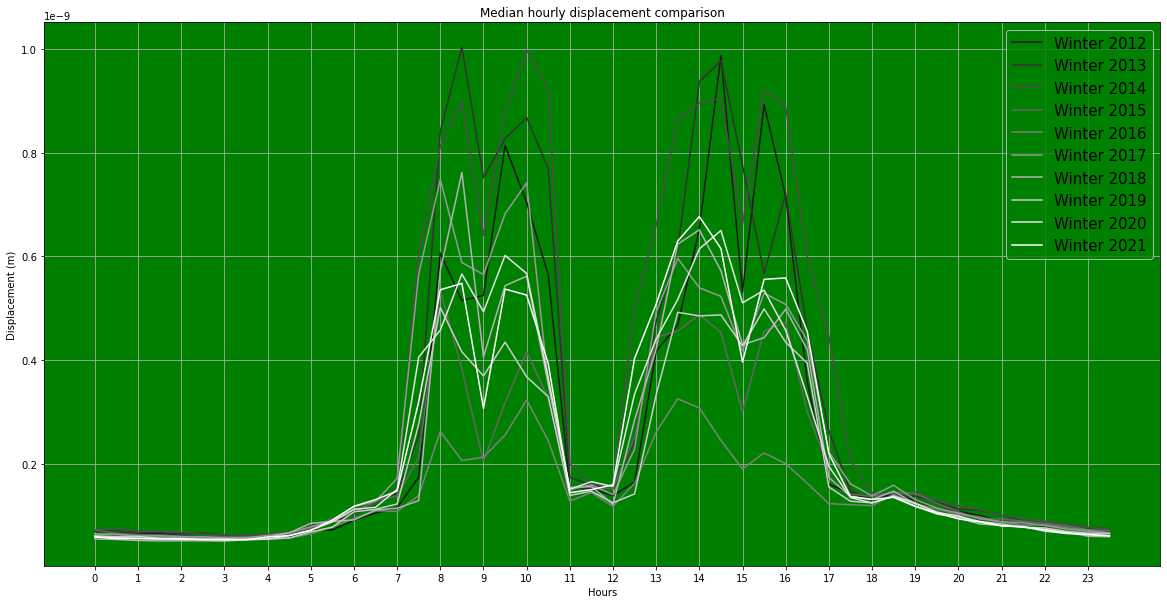

In [11]:
### Paramètres à changer
freq = "2.0-8.0"
st_name = "G.CCD.00.BHZ"
#summer
periods = [[[UTCDateTime("2010-10-01"),UTCDateTime("2011-03-01")]],[[UTCDateTime("2011-10-01"),UTCDateTime("2012-03-01")]],[[UTCDateTime("2012-10-01"),UTCDateTime("2013-03-01")]],[[UTCDateTime("2013-10-01"),UTCDateTime("2014-03-01")]],[[UTCDateTime("2014-10-01"),UTCDateTime("2015-03-01")]],[[UTCDateTime("2015-10-01"),UTCDateTime("2016-03-01")]],[[UTCDateTime("2016-10-01"),UTCDateTime("2017-03-01")]],[[UTCDateTime("2017-10-01"),UTCDateTime("2018-03-01")]],[[UTCDateTime("2018-10-01"),UTCDateTime("2019-03-01")]],[[UTCDateTime("2019-10-01"),UTCDateTime("2020-03-01")]]]
###
#winter
#periods = [[[UTCDateTime("2012-03-01"),UTCDateTime("2012-10-01")]],[[UTCDateTime("2013-03-01"),UTCDateTime("2013-10-01")]],[[UTCDateTime("2014-03-01"),UTCDateTime("2014-10-01")]],[[UTCDateTime("2015-03-01"),UTCDateTime("2015-10-01")]],[[UTCDateTime("2016-03-01"),UTCDateTime("2016-10-01")]],[[UTCDateTime("2017-03-01"),UTCDateTime("2017-10-01")]],[[UTCDateTime("2018-03-01"),UTCDateTime("2018-10-01")]],[[UTCDateTime("2019-03-01"),UTCDateTime("2019-10-01")]],[[UTCDateTime("2020-03-01"),UTCDateTime("2020-10-01")]]]


new_median=[]

for i in periods :

    name = "{}{}_{}".format(st_name, i[0][0].strftime('%Y-%m-%d'), i[0][1].strftime('%Y-%m-%d'))
    noise = dRMS[st_name][freq]
    t, h, noise_matrix = hourly_var(noise, i)
    median1 = np.nanmedian(noise_matrix, axis=1)
    new_median.append(median1.tolist()[indice:] + median1.tolist()[0:indice])


plt.rcParams['figure.figsize'] = 20, 10
plt.rcParams["axes.facecolor"] = 'g'
plt.title('Median hourly displacement comparison')
plt.xlabel('Hours')
plt.ylabel('Displacement (m)' )
c1=2012
colors=0
for i in new_median :
#for i in median1 :
    c2=c1
    c1=c1+1
    colors=colors+0.1
    col=str(colors)
    plt.plot(h,i,label='Winter '+str(c2),color=col)

#plt.plot(test3,test2,color='r', linewidth=2.5,linestyle="--",label='')
plt.xticks(np.arange(0, 24, 1), np.arange(0, 24, 1))
plt.grid()
plt.legend(fontsize=15)
plt.show()

# Variations pour selon le jour de la semaine

In [57]:
dimanche = (3,2,7,6,5,4,2,1,7,6,4)
lundi =    (4,3,1,7,6,5,3,2,1,7,5)
mardi =    (5,4,2,1,7,6,4,3,2,1,6)

In [ ]:
### Paramètres à changer
freq = "2.0-8.0"
st_name = "G.CCD.00.BHZ"
#summer
periods = [[[UTCDateTime("2010-10-01"),UTCDateTime("2011-03-01")]],[[UTCDateTime("2011-10-01"),UTCDateTime("2012-03-01")]],[[UTCDateTime("2012-10-01"),UTCDateTime("2013-03-01")]],[[UTCDateTime("2013-10-01"),UTCDateTime("2014-03-01")]],[[UTCDateTime("2014-10-01"),UTCDateTime("2015-03-01")]],[[UTCDateTime("2015-10-01"),UTCDateTime("2016-03-01")]],[[UTCDateTime("2016-10-01"),UTCDateTime("2017-03-01")]],[[UTCDateTime("2017-10-01"),UTCDateTime("2018-03-01")]],[[UTCDateTime("2018-10-01"),UTCDateTime("2019-03-01")]],[[UTCDateTime("2019-10-01"),UTCDateTime("2020-03-01")]]]
###
#winter
#periods = [[[UTCDateTime("2012-03-01"),UTCDateTime("2012-10-01")]],[[UTCDateTime("2013-03-01"),UTCDateTime("2013-10-01")]],[[UTCDateTime("2014-03-01"),UTCDateTime("2014-10-01")]],[[UTCDateTime("2015-03-01"),UTCDateTime("2015-10-01")]],[[UTCDateTime("2016-03-01"),UTCDateTime("2016-10-01")]],[[UTCDateTime("2017-03-01"),UTCDateTime("2017-10-01")]],[[UTCDateTime("2018-03-01"),UTCDateTime("2018-10-01")]],[[UTCDateTime("2019-03-01"),UTCDateTime("2019-10-01")]],[[UTCDateTime("2020-03-01"),UTCDateTime("2020-10-01")]]]


new_median=[]
new_noise_matrix=[list() for i in range(48)]
iteration = 0

for i in periods :
    name = "{}{}_{}".format(st_name, i[0][0].strftime('%Y-%m-%d'), i[0][1].strftime('%Y-%m-%d'))
    noise = dRMS[st_name][freq]
    t, h, noise_matrix = hourly_var(noise, i)
    nbr_dimanche = len(noise_matrix[0])//7
    
    for k in range (nbr_dimanche) :
        date = k*7 + mardi[iteration] 
        for z in range (0,48) :
            new_noise_matrix[z].append(noise_matrix[z][date:date+1])
        
    median1 = np.nanmedian(new_noise_matrix, axis=1)
    new_median.append(median1.tolist()[indice:] + median1.tolist()[0:indice])
        
    iteration = iteration + 1


plt.rcParams['figure.figsize'] = 20, 10
plt.rcParams["axes.facecolor"] = 'g'
plt.title('Median hourly displacement comparison for Tuesday')
plt.xlabel('Hours')
plt.ylabel('Displacement (m)' )
c1=2010
colors=0
for i in new_median :
#for i in median1 :
    c2=c1
    c1=c1+1
    colors=colors+0.1
    col=str(colors)
    plt.plot(h,i,label='Summer '+str(c2)+'-'+str(c1),color=col)

#plt.plot(test3,test2,color='r', linewidth=2.5,linestyle="--",label='')
plt.xticks(np.arange(0, 24, 1), np.arange(0, 24, 1))
plt.grid()
plt.legend(fontsize=15)
plt.show()